# What Factors affect the Outcome of an NFL game?
## Matthew Oliver
## CMSC 320 Final Tutorial

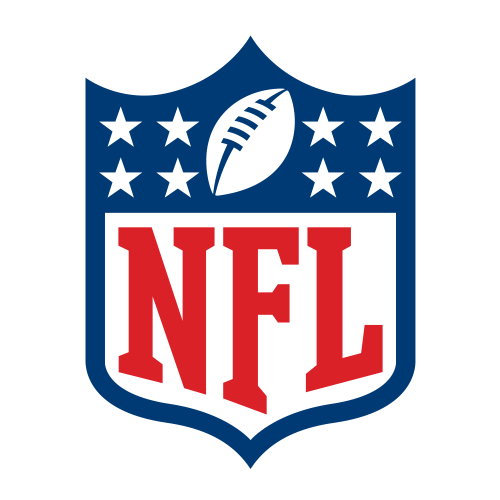

## Why is this Important?

Among the North American professional sports, there is little doubt that the NFL is the most popular. In 2021, the NFL accounted for 75 of the top 100 [most watched television programs](https://sportsbusinessjournal.com/Journal/Issues/2022/01/10/Upfront/Ratings.aspx). This immense popularity, paired with the rise in legalized sports betting has meant that there is a lot of money to be made in correctly predicting the outcome of NFL games. While I won't try to replicate the highly sophisticated models used by the sportsbooks, I thought it would be interesting to look at previous NFL games and try to determine which factors most affect their outcome. 

## NFL Overview 
The NFL currently consists of 32 teams in two conferences: the AFC and NFC. Each 16-team conference is made up of 4 divisions of four teams each. Each team plays a 17 game schedule over the span of 18 weeks, and the top 7 teams from each conference advance to a single-elimination playoff after all 17 games have been played. This playoff culminates in the super bowl.

Note: prior to 2021, there were only 16 games in a season, not 17. Also, prior to 2020, there were only 6 teams per conference in the playoffs, not 7. I don't anticipate either of these changes will have an effect on the analysis.

For this project, I will only be looking at games from the 2002 season onwards. In 2002, the NFL underwent realignment and added the expansion Houston Texans as the 32nd team. I think that this is a good cut off, as the game has changed significantly over time, and I feel that games from over twenty years ago might not be helpful for analyzing games today. 2002 was also the first season using the current division format, so it feels like a good year to use as the cutoff.

## What Factors Might Impact a Game's Results?

It seems obvious that the difference in skill between the two teams will have the greatest effect on the results. If we were to simply pick the better team in every game, we would likely get relatively good accuracy. But there are other factors that may affect a game's outcome, such as which team was at home, whether the game was a division game, or if the game took place during the playoffs. In my time following the NFL, I have heard many claims about these questions and there are many theories about the effects of these factors. In this analysis, I want to examine some of these claims to see if there is any validity to them.

## How to Define Which Team is Better?

When trying to evaluate which team is better, it's important to use a reliable metric. The most commonly used metric to compare two teams is their record or win percentage. It feels like common sense that the team with the higher win percentage is likely better, and this is probably true most of the time. However, there are some flaws in using a team's record. For example, early in the season, when not many games have been played, a team's record is a very small sample size which can be misleading. Take team A, for example, who starts the season 0-2, with both losses by three points on the road against playoff teams from the previous season. Now, team B, on the other hand, starts 2-0, by narrowly winning two home games against subpar teams from the previous season. Using all the information available, it seems reasonable to believe that team A is the better team, even though their records wouldn't indicate this. To properly gauge which team is better, we will need a more sophisticated metric that takes into account the context of a team's previous results. 

## FiveThirtyEight ELO

The statictics and news website [FiveThirtyEight's NFL predictions model](https://projects.fivethirtyeight.com/2022-nfl-predictions/) is one of the main public-facing NFL models available. They use an [ELO-based system](https://en.wikipedia.org/wiki/Elo_rating_system), similar to ones used in chess, to give each team a numerical rating. After each game, these ratings are updated based on the results. These ratings have a mean of 1500, and a difference of 100 ELO points between two teams should, hypothetically, mean that the better team will win 64% of the time. The more unexpected the game's results are, the bigger the change in the team's ratings. For example, if a team with a high ELO rating loses to a team with a low rating, the higher team's rating will fall significantly, and the lower team's will increase significantly. ELO ratings are zero-sum, so the winning team's rating increases by the same amount that the losing team's decreases, meaning the sum of the ELO points of all 32 teams never changes. [In FiveThirtyEight's model](https://fivethirtyeight.com/methodology/how-our-nfl-predictions-work/), adjustments are made to each team's ELO-rating before each game to account for home-field advantage, whether one team is coming off their bye week, if the game is a playoff game, and number of miles traveled by the visiting team. For this analysis, I will not be looking at the ELO values after these adjustments are made. I want to do my own analysis on these factors, and using their adjustments will defeat the purpose of this analysis. I will only use the team's un-adjusted ELO rating from before each game in order to have a good measure of a team's relative skill level. 

I am fairly confident that a team's ELO rating is going to be the biggest predictor of an NFL game's outcome. However, there are many other factors that could have an affect, albeit to a lesser degree. Put together, however, these "smaller" factors can still have a big effect on a game's predicted outcome. For example, in the NFL this week (week of December 11, 2022), the 10-2 Minnesota Vikings are two-point underdogs to the 5-7 Detroit Lions according to Vegas. Even though Minnesota's ELO rating is 148 points higher, which should signify a 70% win percentage, the sportsbooks expect them to lose. It's clear that other factors need to be considered in order to more accurately predict a game's outcome.

Before we examine these further, let's import the data that I will use for for this analysis. I will start by using FiveThirtyEight's game data csv, which includes every NFL game in history, and their outcomes, as well as the ELO values used by the 538 model. Like I mentioned before, I am only concerened with the un-adjusted team ELO values. 

Luckily, the dataset is in csv format, so we can easily import it using Pandas' read_csv function. If the data we wanted to use was on a webpage, we would need to scrape it, which can be tedious. The csv we will be represented as a Pandas dataframe. This is a useful object that will allow us to more easily perform operatoins on the data. Before we can begin the analysis, we must tidy up the dataframe to get rid of unneccessary columns and make sure that each column is the proper type. These steps are outlined in the code below.

In [137]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import ttest_ind

In [138]:
df = pd.read_csv("nfl_elo.csv")

#I will drop the columns that I will not be using. 
df = df.drop(columns = ["elo_prob1","elo_prob2","elo1_post","elo2_post","qbelo1_pre","qbelo2_pre","qb1_value_post",
                       "qb2_value_post","qbelo_prob2","qbelo_prob1","qb2_adj","qb1_adj"
                        ,"qbelo1_post","qbelo2_post","quality","importance","total_rating"
                         ,"qb1_game_value","qb2_game_value","qb1","qb2","qb1_value_pre","qb2_value_pre"],axis = 1)

#Rename the columns to be more readable
df = df.rename(columns = {'team1':'home','team2':'away','elo1_pre':'home_elo','elo2_pre':'away_elo','score1':'home_score','score2':'away_score'})

#Remove all games prior to 2002
df = df[df["season"] >= 2002]

#Update abbreviations to remove old abbreviations of relocated teams
df["home"] = df["home"].apply(lambda x: "LAR" if x == "STL" else x)
df["away"] = df["away"].apply(lambda x: "LAR" if x == "STL" else x)

df["home"] = df["home"].apply(lambda x: "LAC" if x == "SD" else x)
df["away"] = df["away"].apply(lambda x: "LAC" if x == "SD" else x)

df["home"] = df["home"].apply(lambda x: "LV" if x == "OAK" else x)
df["away"] = df["away"].apply(lambda x: "LV" if x == "OAK" else x)

#Turn the playoff and neutral column into booleans
df["playoff"] = df["playoff"].apply(lambda x: True if (x == 'w' or x == 'd' or x == 'c' or x == 's' )else False)
df["neutral"] = df["neutral"].apply(lambda x: True if x == 1 else False)

#Turn the dates into datetime objects
df["date"] = df["date"].apply(lambda x: pd.to_datetime(x))

#Remove games that occur after 11/29/22, as they haven't occurred yet
endingdate = dt.date(2022, 11, 29)
endingdate = pd.to_datetime(endingdate)
df = df[df["date"] < endingdate]

print("Number of Unique Teams: " + str(len(df["home"].value_counts())))
df.head()

Number of Unique Teams: 32


,date,season,neutral,playoff,home,away,home_elo,away_elo,home_score,away_score
11735,2002-09-05,2002,False,False,NYG,SF,1485.669,1561.242,13.0,16.0
11736,2002-09-08,2002,False,False,TB,NO,1547.200,1450.990,20.0,26.0
11737,2002-09-08,2002,False,False,JAX,IND,1484.758,1492.006,25.0,28.0
11738,2002-09-08,2002,False,False,TEN,PHI,1516.957,1613.455,27.0,24.0
11739,2002-09-08,2002,False,False,CAR,BAL,1370.952,1572.940,10.0,7.0


Above is a small chunk of the dataframe. As seen in the table above, the rows represent different games, while the columns keep track of the information about each game. There are also 32 unique team abbreviations present, which is the correct number. In the past 20 years, a few teams have changed cities, hence changing their abbreviation. I wanted to make sure that all teams had their most recent abbreviations.

#### Overview of columns: 
###### date: The date the game was played on
###### season: The NFL season the game took place in (not neccessarily the calendar year)
###### neutral: Was the game played at the home team's stadium, or at a neutral site?
###### playoff: Was the game a playoff game?
###### home: The abbreviation of the home team
###### away: The abbreviation of the away team
###### home_elo: The ELO value of the home team
###### away_elo: The ELO value of the away team
###### home_score: Number of points scored by the home team
###### away_score: Number of points scored by the away team

## Getting Betting Line Information

One of the factors I will look at later in the analysis is the predicted point spread in Vegas. This is the most common metric used to determine a "favorite" before a game. The FiveThirtyEight dataframe does not include this information, so I will have to use another source. Luckily, I found a dataset on Kaggle that has much of the same information as the 538 dataset, but includes the vegas line. After I clean up this dataset, I will merge the two, so I can have one dataframe that has vegas point spreads, elo values, and scores.

## Cleaning the Betting Dataset

In [139]:
bettingdf = pd.read_csv("nfllocationdata.csv")

#Remove games prior to 2002
bettingdf = bettingdf[bettingdf["schedule_season"] >= 2002]

#Create a dictionary mapping full team names to their corresponding abbreviation
team_name_dict = {"Arizona Cardinals": "ARI","Atlanta Falcons":"ATL","Baltimore Ravens":"BAL","Buffalo Bills":"BUF",
                  "Carolina Panthers":"CAR","Chicago Bears":"CHI","Cincinnati Bengals":"CIN","Cleveland Browns":"CLE",
                  "Dallas Cowboys":"DAL","Denver Broncos":"DEN","Detroit Lions":"DET","Green Bay Packers":"GB",
                  "Houston Texans":"HOU","Indianapolis Colts":"IND","Jacksonville Jaguars":"JAX","Kansas City Chiefs":"KC",
                  "Los Angeles Chargers":"LAC","Los Angeles Rams":"LAR","Las Vegas Raiders":"LV","Miami Dolphins":"MIA",
                  "Minnesota Vikings":"MIN","New England Patriots":"NE","New Orleans Saints":"NO","New York Giants":"NYG",
                  "New York Jets":"NYJ","Philadelphia Eagles":"PHI","Pittsburgh Steelers":"PIT","Seattle Seahawks":"SEA",
                  "San Francisco 49ers":"SF","Tampa Bay Buccaneers":"TB","Tennessee Titans":"TEN","Washington Commanders":"WSH",
                  "St. Louis Rams":"LAR","Oakland Raiders":"LV","Washington Football Team":"WSH","Washington Redskins":"WSH",
                  "San Diego Chargers":"LAC"}

#Replacing full names with abbreviations
bettingdf["team_home"] = bettingdf["team_home"].apply(lambda x: team_name_dict.get(x))
bettingdf["team_away"] = bettingdf["team_away"].apply(lambda x: team_name_dict.get(x))

bettingdf = bettingdf.rename(columns = {'team_home':'home','team_away':'away','schedule_date':'date','schedule_season':'season',
                                         'schedule_week':'week','schedule_playoff':'playoff','stadium_neutral':'neutral'})

#Turn the dates into datetime objects
bettingdf["date"] = bettingdf["date"].apply(lambda x: pd.to_datetime(x))

#Remove games that occur after 11/29/22, as they haven't occurred yet
bettingdf = bettingdf[bettingdf["date"] < endingdate]

#Check to make sure the number of teams is correct
print("Number of Unique Home Teams: " + str(len(bettingdf["home"].value_counts())))
print("Number of Unique Away Teams: " + str(len(bettingdf["away"].value_counts())))

#Drop columns we won't be using
bettingdf = bettingdf.drop(columns = ["over_under_line","stadium","weather_temperature","weather_wind_mph","weather_humidity",
                                     "weather_detail"],axis = 1)

bettingdf.head()

Number of Unique Home Teams: 32
Number of Unique Away Teams: 32


,date,season,week,playoff,home,score_home,score_away,away,team_favorite_id,spread_favorite,neutral
7872,2002-09-05,2002,1,False,NYG,13.0,16.0,SF,SF,-4.0,False
7873,2002-09-08,2002,1,False,BUF,31.0,37.0,NYJ,NYJ,-3.0,False
7874,2002-09-08,2002,1,False,CAR,10.0,7.0,BAL,PICK,0.0,False
7875,2002-09-08,2002,1,False,CHI,27.0,23.0,MIN,CHI,-4.5,False
7876,2002-09-08,2002,1,False,CIN,6.0,34.0,LAC,CIN,-3.0,False


## Merging the Dataframes

In order to combine both dataframes, we will need to use the [merge operation](https://www.w3schools.com/python/pandas/ref_df_merge.asp). Using merge, you specify the columns to merge on, and rows in the two dataframes that match in all of the specified columns will be combines. In this case, I will merge on season, playoff, home, and away. Since each home/away matchup can only happen once during the NFL regular season, this will make each game unique. I will perform an outer merge in this step. This means that if there is a game in one dataframe that is not in the other, it will still be added to the new dataframe. If the two dataframes match up perfectly, then the new dataframe should be the same size as the previous two.

In [140]:
joineddf = df.merge(bettingdf,how = 'outer',on = ['season','playoff','home','away'])
joineddf.head()

,date_x,season,neutral_x,playoff,home,away,home_elo,away_elo,home_score,away_score,date_y,week,score_home,score_away,team_favorite_id,spread_favorite,neutral_y
0,2002-09-05,2002,False,False,NYG,SF,1485.669,1561.242,13.0,16.0,2002-09-05,1,13.0,16.0,SF,-4.0,False
1,2002-09-08,2002,False,False,TB,NO,1547.200,1450.990,20.0,26.0,2002-09-08,1,20.0,26.0,TB,-6.0,False
2,2002-09-08,2002,False,False,JAX,IND,1484.758,1492.006,25.0,28.0,2002-09-08,1,25.0,28.0,IND,-3.5,False
3,2002-09-08,2002,False,False,TEN,PHI,1516.957,1613.455,27.0,24.0,2002-09-08,1,27.0,24.0,TEN,-2.0,False
4,2002-09-08,2002,False,False,CAR,BAL,1370.952,1572.940,10.0,7.0,2002-09-08,1,10.0,7.0,PICK,0.0,False


Now, the two dateframes have been merged. Each row now has two entries for each score, with one corresponding to the game from each dataframe. I will run a quick operation to make sure the score columns match up between dataframes.

In [141]:
problemdf = joineddf[joineddf["score_home"] != joineddf["home_score"]]
print("Number of games where the scores don't matchup up between dataframes: " + str(len(problemdf)))
print("FiveThirtyEight dataframe size: " + str(len(df)))
print("Betting dataframe size: " + str(len(bettingdf)))
print("Joined dataframe size: " + str(len(joineddf)))

Number of games where the scores don't matchup up between dataframes: 54
FiveThirtyEight dataframe size: 5540
Betting dataframe size: 5540
Joined dataframe size: 5566


After merging, there were 54 games where the scores didn't line up between dataframes. Since an outer merge adds all entries that don't match up, these 54 games should be double the actual number of games where there is a problem, since each game will have two entries (the entry from the 538 dataframe and one from the betting dataframe). This is a problem, as some games appear in the joined dataframe multiple times.

One way to remedy this would be to do an inner merge, which looks at the intersection of the two dataframes. This only merges entries where both dataframes have correspoding entries. So if a game doesn't match up between dataframes, it isn't included in the merged dataframe. This will result in a dataframe that doesn't have duplicate rows, but the games that match up won't be present, making the data imcomplete. This feels like taking the easy way out. If we omit the games that don't line up, the analysis will probably be fine, as the number of affected games is small, but we want to be thourough, so we should at least see what properties these games have before making the decision to omit them.

Another way to fix this, would be to manually look a the values of the columns being joined between dataframes. This will be more tedious than the prior approach, but will give us a better understanding of the games where a problem occurred. Let's try this, as it will be a good exercise in cleaning data.

First, let's look at playoff games. If the number of playoff games is the same between the betting and 538 dataframes, then it is unlikely that the playoff column is where the discrepancy is.

In [142]:
#Check to see if playoff values differ between the two dataframes
print(df["playoff"].value_counts())
print(bettingdf["playoff"].value_counts())

False    5316
True      224
Name: playoff, dtype: int64
False    5316
True      224
Name: playoff, dtype: int64


The playoff values are the same, so this is unlikely to be the culprit. Now, let's check the season year values. NFL seasons are played from September-February, which is across two calendar years. However, the earlier year is the official "season." For example, the 2022 NFL season will end in 2023, but the 2023 season won't start until September, 2023. Maybe some entries were incorrectly labeled with the calendar year instead of the official season year.

In [143]:
#Get a list of the number of games in each season for both dataframes
season_538df_counts = df["season"].value_counts().to_list()
season_bettingdf_counts = bettingdf["season"].value_counts().to_list()

numOfSeasonsDiffered = 0 #Checks how many years the two dataframs season values differ
for i in range(21):
    if (season_538df_counts[i] != season_bettingdf_counts[i]):
        numOfSeasonsDiffered = numOfSeasonsDiffered + 1
        
print("Number of Discrepancies: " + str(numOfSeasonsDiffered))

Number of Discrepancies: 0


The season column also appears to have no discrepancies. It looks like the errors will come down to the home and away columns. One potential discepancy could occur in the handling of neutral site games. Most games are played in the home team's stadium, but there are some cases where games are played elsewhere. A few times a year, games are played internationally, usually in Mexico City or London. There are also times when games are played at other NFL stadiums due to extreme weather in the home cities. In the FiveThirtyEight dataset, the team columns weren't labeled home or away, but I assumed that's what they represented after I looked at recent games and noticed that the home teams were always in the left column. I probably shouldn't have assumed this, so let's see if this is the culprit. Let's first make sure both dataframes have the same number of neutral site games. 

In [144]:
#Check to see if neutral values differ between the two dataframes
print(df["neutral"].value_counts())
print(bettingdf["neutral"].value_counts())

False    5475
True       65
Name: neutral, dtype: int64
False    5468
True       72
Name: neutral, dtype: int64


These do not match up. Let's try to find which games differ between the dataframes.

In [145]:
#neutral site games in the 538 dataframe
neutral538 = df[df["neutral"] == True]

#neutral site games in the betting dataframe
neutralbetting = bettingdf[bettingdf["neutral"] == True]

#outer merge the two dataframes to include games where one of the two dataframes didn't classify a game as neutral.
mergedneutraldf = neutral538.merge(neutralbetting,how = 'outer', on =['date','season'])
print("Length of merged dataframe: " + str(len(mergedneutraldf)))

#Dataframe where the neutral column doesn't match
mergedproblemdf = mergedneutraldf[mergedneutraldf["neutral_x"] != mergedneutraldf["neutral_y"]]

mergedproblemdf.head(10)

Length of merged dataframe: 75


,date,season,neutral_x,playoff_x,home_x,away_x,home_elo,away_elo,home_score,away_score,week,playoff_y,home_y,score_home,score_away,away_y,team_favorite_id,spread_favorite,neutral_y
57,2021-02-07,2020,True,True,TB,KC,1703.303296,1741.087279,31.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,2008-12-07,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,False,BUF,3.0,16.0,MIA,BUF,-2.0,True
68,2009-12-03,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,False,BUF,13.0,19.0,NYJ,NYJ,-3.5,True
69,2010-11-07,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,False,BUF,19.0,22.0,CHI,CHI,-3.0,True
70,2011-10-30,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,False,BUF,23.0,0.0,WSH,BUF,-4.0,True
71,2012-12-16,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,BUF,17.0,50.0,SEA,SEA,-5.0,True
72,2013-12-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,False,BUF,31.0,34.0,ATL,BUF,-4.5,True
73,2020-12-07,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,False,SF,24.0,34.0,BUF,SF,-1.5,True
74,2022-11-20,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,False,BUF,31.0,23.0,CLE,BUF,-7.5,True


Overall, there were 9 games where problems occurred. 8 of these are classifed as neutral in the betting dataframe, but classified as non-neutral by 538. Only 1 game was classified as neutral by 538 and not by the betting dataframe. So, what were the games? Well, after doing some research, six of the games were part of the Buffalo Bills Canada series, which were annual games from 2008-2013 where the Bills played one of their home games in nearby Toronto. It seems like 538 did not classify this as neutral due to Toronto being close to Buffalo. One of the other games was in 2020, when the San Francisco 49ers had to move their home games to Arizona due to local COVID regualations. However, the In 2022, the Buffalo Bills had to move a home game to Detroit due to a Winter Storm. In both of these cases, as well, 538 did not classify the game as neutral. Whether these games were actually neutral is clearly up for interpretation. For this analysis, I will classify them as neutral. The last game where a discrepancy occurred was the 2020 Super Bowl between the Tampa Bay Buccaneers and the Kansas City Chiefs. Normally, the Super Bowl is played at a neutral site determined several years in advance. However, in 2020, the Tampa Bay Buccaneers happened to make the Super Bowl in the same year that Tampa was hosting the game. For this analysis, since the Super Bowl brings different routines than a normal home game, and since there are always lots of fans from both teams in attendance, I will classify this game as a neutral site game.

Finally, there was one more error I noticed. Like I mentioned earlier, the 2020 San Franciso 49ers had to [play their final three home games in Arizona](https://www.cbssports.com/nfl/news/49ers-will-play-in-arizona-for-remainder-of-2020-season-after-covid-19-restrictions-extended-in-santa-clara/) due to local COVID regulations. However, in the betting dataframe, this change is only reflected in the first of the three games. I will need to manually update the other two games. 

In [146]:

# Updating the neutral site values and the two 2020 49ers games
bettingdf.at[12882,'neutral'] = True # 2020 SF vs WSH
bettingdf.at[12932,'neutral'] = True # 2020 SF vs SEA
bettingdf.at[12946,'neutral'] = True # 2020 Super Bowl TB vs KC

#Drop the neutral values from the 538 df, since we will be using the values from the betting dataframe
df = df.drop("neutral",axis = 1)


Now that we've correctly classified all of the neutral site games, we still need to address the discrepancies between the home and away columns in neutral site games. Like I mentioned before, my hunch is that for neutral site games, the 538 columns might have flipped the home/away columns. Now that we know which games affected the merge, we can decide if we want to manually fix all of the neutral site games or omit them. 

Because neutral site games are such a small percentage of the overall games, I don't think we would be able to confidently compare the results of neutral site games to regular games. Additionally, a lot of our analysis will look a the effects of home field advantage, for which neutral site games won't be useful. For these reasons, I think it is safe to proceed without neutral site games. Now, let's re-merge the dataframes and drop the neutral site games.   

# Exploratory Data Analysis and Data Visualization

I will also add two new columns:

#### elo_dif: The difference in ELO values between the two teams. A postive elo_dif means the home team has a higher elo, and a negative elo_dif means the road team is higher.

#### point_dif: The margin of victory (or defeat) for the home team. A positive point_dif means a victory for the home team and a negative one means the road team won. A point_dif of zero means a tie occurred.

In [147]:
# Keep a dataframe with the neutral site games for later
neutralsitegames = bettingdf[bettingdf["neutral"] == True]

# Re-merge the two dataframes.
bettingdf = bettingdf[bettingdf["neutral"] == False]
joineddf = bettingdf.merge(df, how = "inner", on = ["date","season","playoff","home","away"])

#drop the score columns from the betting dataframe, as this information is already included from the 538 df
joineddf = joineddf.drop(["score_home","score_away"],axis = 1)

In [148]:
joineddf["point_dif"] = 0
joineddf["elo_dif"] = 0

#Create columns elo_dif and point_dif to show the difference between the elo and point values.
for index, row in joineddf.iterrows():
    joineddf.at[index,"point_dif"] = joineddf.at[index,"home_score"] - joineddf.at[index,"away_score"]
    joineddf.at[index,"elo_dif"] = joineddf.at[index,"home_elo"] - joineddf.at[index,"away_elo"]
    
# Assign a week number for playoff weeks
joineddf["week"] = joineddf["week"].apply(lambda x: 19 if x == "WildCard" or x == "Wildcard" else x)
joineddf["week"] = joineddf["week"].apply(lambda x: 20 if x == "Conference" else x)
joineddf["week"] = joineddf["week"].apply(lambda x: 21 if x == "Divisional" or x == "Division" else x)
joineddf["week"] = joineddf["week"].apply(lambda x: 22 if x == "SuperBowl" or x == "Superbowl" else x)
joineddf["week"] = joineddf["week"].apply(lambda x: int(x))


Let's start by creating some broad graphs to visualize the outcomes of NFL games. First, we'll look at point differential. I will use a histogram for this, as they are a great way to look at frequencies. 

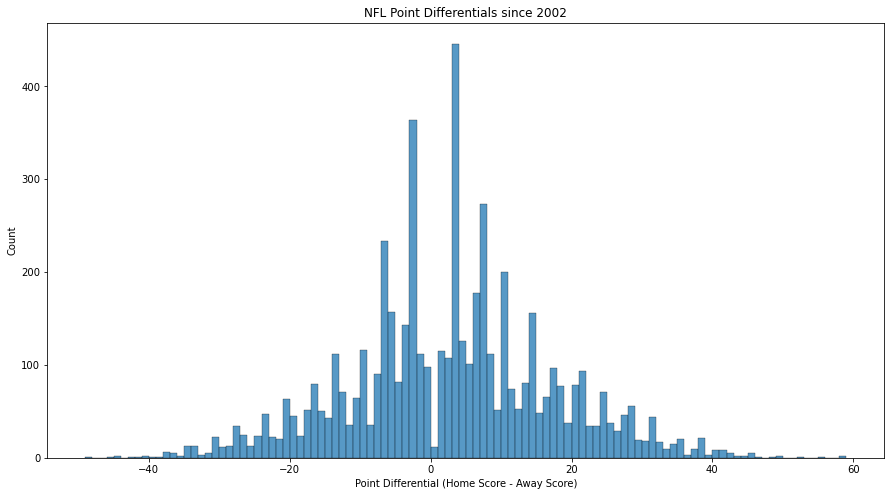

In [149]:
point_dif_plot = seaborn.histplot(data = joineddf["point_dif"],binwidth = 1).set(title = "NFL Point Differentials since 2002",
                                                                                xlabel = "Point Differential (Home Score - Away Score)")

plt.gcf().set_size_inches(15, 8)

In [150]:
print("Mean Point Differential: " + str(joineddf["point_dif"].mean()))
print("Median Point Differential: " + str(joineddf["point_dif"].median()))
print("Point Differential Standard Deviation: " + str(joineddf["point_dif"].std()))

Mean Point Differential: 2.3330283623055807
Median Point Differential: 3.0
Point Differential Standard Deviation: 14.635279786123647


Based on the graph, it appears that home teams win slightly more often than they lose. This graph also hightlights some of the interesting properties of NFL scores. Notice how there are local maximums at the point_dif values of plus/minus 3, 7, 10, 14, 17, and 21. This is due to the fact that in the NFL, scoring happens in increments of 3 and 7, due to field goals and touchdowns usually being worth 3 and 7 point respectively. Touchdowns can be worth 6 or 8 points, depending on if the extra point is missed or the team attempts a two-point conversion, but these events are somewhat rare. This explains why the most common point differentials are combinations of 3 and 7. Another interesting property is how there are very few games with a point differential of zero. These are ties, and they only occur when teams are still tied after an overtime period. That is, if two teams are tied at the end of the game, the NFL extends the game to try and determine a winner. This makes it very rare for a game to end in a tie. [Since overtime was introduced in 1974](https://en.wikipedia.org/wiki/List_of_NFL_tied_games#Tied_games_(1974%E2%80%932011)), only 3.4% of games that went into overtime ended in a tie.

Another important item to note from this analysis is the fairly high standard deviation of 14.6. While the median result of a game is the home team winning by 3 points, a standard deviation of 14.6, means that there are a wide range of likely outcomes. 

Let's now take ELO values into account and make a scatter plot of Point Differential vs ELO differential. I will use a seaborn regression plot for this. These plots scatter the data based on elo_dif and point_dif and then draw a line of best fit to help show the relationship betwen the two variables.

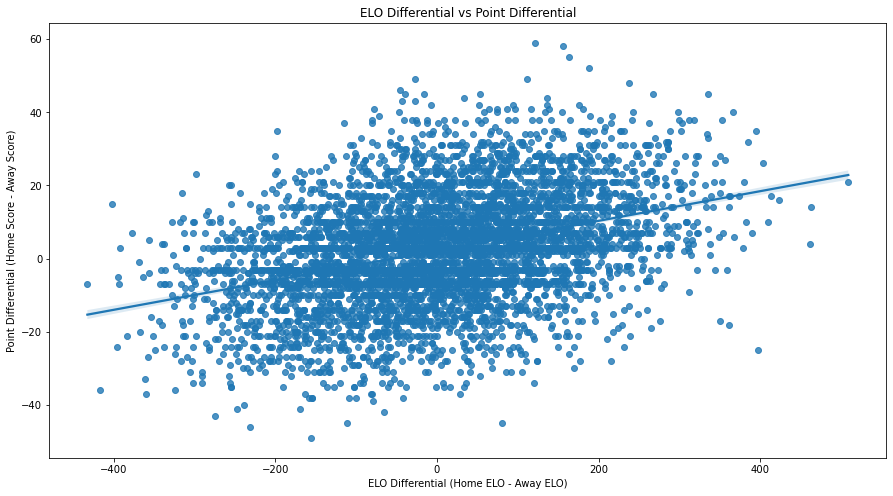

In [151]:
point_dif_elo_scatter = seaborn.regplot(y=joineddf["point_dif"],x=joineddf["elo_dif"]).set(title = "ELO Differential vs Point Differential",
                                                                                ylabel = "Point Differential (Home Score - Away Score)"
                                                                                             ,xlabel = "ELO Differential (Home ELO - Away ELO)")
plt.gcf().set_size_inches(15,8)

Based on this regression plot, ELO differential and point differential appear to be positively correlated. That is, to say, if the home team has a higher ELO, they are more likely to win, and vice-versa. However, more analysis is needed to determine the strength of this relationship. Let's look at some statistics from this linear regression. 

In [152]:
mod = smf.ols(formula='point_dif ~ elo_dif', data=joineddf)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              point_dif   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     890.0
Date:                Fri, 16 Dec 2022   Prob (F-statistic):          2.65e-181
Time:                        11:53:00   Log-Likelihood:                -22007.
No. Observations:                5465   AIC:                         4.402e+04
Df Residuals:                    5463   BIC:                         4.403e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2313      0.184     12.151      0.0

The main thing that jumps out here is the R-squared value of .14. This indicates that 14% of the variance in point differential can be explained by elo differential in this linear model. An r-squared value closer to 1 would indicate a much stronger relatonship. As it stands right now, only a small part of the variance in point differential can be explained by elo differential. With that being said, the p-values are small, which indicated that there is a relationship between the two variables. The only issue is that it's a relatively weak relationship, which indicates that there are other factors that affect a game's outcome. 

Another thing to keep in mind is the random nature of an NFL game. An NFL game is only 60 minutes long, and that includes a lot of downtime. With an NFL game being a somewhat small sample of the two team's abilities, it seems likely that a lot of the variance in point differential is just randomness. After all, if NFL games could be predicted by just looking at a few criteria, what's the point of even playign the games? Like I mentioned before, I think ELO differential is the biggest predictor of point differential, and as we have just shown, the relationship isn't the strongest. This highlights the reality that sports are very hard to predict. With that being said, I think there are more factors we can consider to improve our analysis. 

Now, I will take a look at how point differetial changes for playoff games, division games, and based on the number of days teams have had since their last game. 

## Division Games

Like I mentioned in the intro, the NFL is split into two conferences of 16 teams each, and each conference is made up of 4 divisions of 4 teams each. Every team plays the other teams in its division twice, for a total of six divisional games for each team each season. There is an incentive to be the best team in your division, as that team will automatically receive a playoff spot. Additonally, there are often rivalries within divisions, which might provide further motivation to win. Some people claim that due to teams in the same division having familiarity with each other, that record (or ELO) is "thrown out the window" for divisional games. Let's take a look at if there is any validity to these claims. 

First, we will need to classify each game in the dataframa as a divisional game. I also want to add a column to the dataframe that indicated if the "better" team in terms of ELO values won. I will use this information a bit later.

In [153]:
# Create a dictionary mapping team abbreviations to divisions
division_dict = {"CHI":"NFC North","DET":"NFC North","GB":"NFC North","MIN":"NFC North",
                 "ATL":"NFC South","CAR":"NFC South","NO":"NFC South","TB":"NFC South",
                 "DAL":"NFC East","NYG":"NFC East","PHI":"NFC East","WSH":"NFC East",
                "ARI":"NFC West","LAR":"NFC West","SEA":"NFC West","SF":"NFC West",
                "BAL":"AFC North","CIN":"AFC North","CLE":"AFC North","PIT":"AFC North",
                 "HOU":"AFC South","IND":"AFC South","JAX":"AFC South","TEN":"AFC South",
                 "BUF":"AFC East","MIA":"AFC East","NE":"AFC East","NYJ":"AFC East",
                "DEN":"AFC West","KC":"AFC West","LAC":"AFC West","LV":"AFC West"}

joineddf["division_game"] = False #initialize the division_game column
joineddf["better_team_won"] = False #initialize the column that indicates if the higher elo team won
for index, row in joineddf.iterrows():
    away_div = division_dict.get(joineddf.at[index,"away"])
    home_div = division_dict.get(joineddf.at[index,"home"])
    joineddf.at[index,"division_game"] = (away_div == home_div)
   
    # Multiplies the ELO differential by the point differential. If this number is positive, it means that 
    # the "better" team won, since a negtive point differential and a negative elo differential means that the
    # road team won and had a higher ELO rating. Same for a positive elo rating and point differential.
    point_dif_elo_comb = joineddf.at[index,"point_dif"]*joineddf.at[index,"elo_dif"]
    
    joineddf.at[index,"better_team_won"] = (point_dif_elo_comb > 0)
        
        
# Create two new dataframes. One fore division games and one for non-division games
divisiondf = joineddf[joineddf["division_game"] == True]
nondivisiondf = joineddf[joineddf["division_game"] == False]

joineddf.head()
    
                 

,date,season,week,playoff,home,away,team_favorite_id,spread_favorite,neutral,home_elo,away_elo,home_score,away_score,point_dif,elo_dif,division_game,better_team_won
0,2002-09-05,2002,1,False,NYG,SF,SF,-4.0,False,1485.669,1561.242,13.0,16.0,-3,-75.573,False,True
1,2002-09-08,2002,1,False,BUF,NYJ,NYJ,-3.0,False,1413.251,1535.438,31.0,37.0,-6,-122.187,True,True
2,2002-09-08,2002,1,False,CAR,BAL,PICK,0.0,False,1370.952,1572.940,10.0,7.0,3,-201.988,False,False
3,2002-09-08,2002,1,False,CHI,MIN,CHI,-4.5,False,1565.787,1452.964,27.0,23.0,4,112.823,True,True
4,2002-09-08,2002,1,False,CIN,LAC,CIN,-3.0,False,1417.743,1407.844,6.0,34.0,-28,9.899,False,False


Now, let's look at the same graphs as above, but this time differentiate between division games and non-division games.

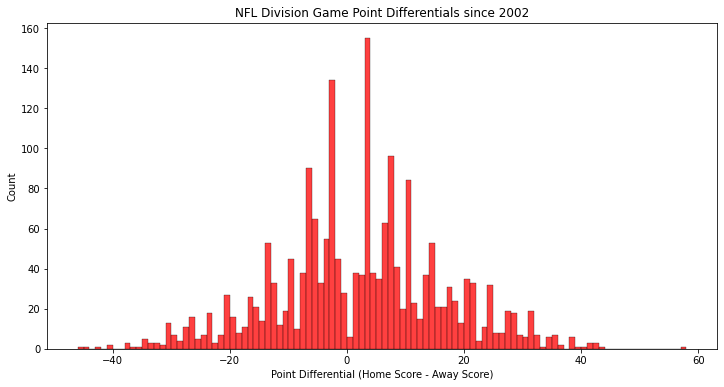

In [154]:
point_dif_plot = seaborn.histplot(data = divisiondf["point_dif"],binwidth = 1,color = 'red').set(title = "NFL Division Game Point Differentials since 2002",
                                                                                xlabel = "Point Differential (Home Score - Away Score)")

plt.gcf().set_size_inches(12, 6)

In [155]:
print("Mean Division Point Differential: " + str(divisiondf["point_dif"].mean()))
print("Median Division Point Differential: " + str(divisiondf["point_dif"].median()))
print("Division Point Differential Standard Deviation: " + str(divisiondf["point_dif"].std()))

Mean Division Point Differential: 1.6904881731253145
Median Division Point Differential: 3.0
Division Point Differential Standard Deviation: 14.571189452051247


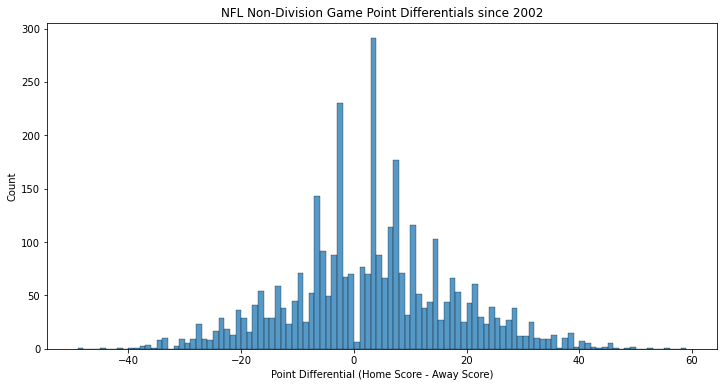

In [156]:
point_dif_plot = seaborn.histplot(data = nondivisiondf["point_dif"],binwidth = 1).set(title = "NFL Non-Division Game Point Differentials since 2002",
                                                                                xlabel = "Point Differential (Home Score - Away Score)")

plt.gcf().set_size_inches(12, 6)

In [157]:
print("Mean Non-Division Point Differential: " + str(nondivisiondf["point_dif"].mean()))
print("Median Non-Division Point Differential: " + str(nondivisiondf["point_dif"].median()))
print("Non-Division Point Differential Standard Deviation: " + str(nondivisiondf["point_dif"].std()))

Mean Non-Division Point Differential: 2.700115008625647
Median Non-Division Point Differential: 3.0
Non-Division Point Differential Standard Deviation: 14.661222941499453


After splitting up division and non-division games, the two graphs look very similar. However, in division games, the home teams won by an average of 1.69 points, versus by 2.7 points on average in non-division games. Since the standard deviations of the two groups are nearly identical, this seems to indicate that there is less of a home-field advantage in division games. Let's also look at if the "better" team in terms of ELO value wins more often in division games, and then run some hypothesis tests to see if the differences between the two groups are statistically significant.

In [158]:
print("Win percentage of better team in division games: " + str(len(divisiondf[divisiondf["better_team_won"] == True])/
                                                               len(divisiondf)))

print("Win percentage of better team in non-division games: " + str(len(nondivisiondf[nondivisiondf["better_team_won"] == True])/
                                                               len(nondivisiondf)))

Win percentage of better team in division games: 0.6396577755410167
Win percentage of better team in non-division games: 0.6196089706728004


Since 2002, the team with the higher ELO rating appears to win 2% more often in division games. This seems to indicate that ELO is a more accurate predictor in division games. Maybe due their added importance, better teams take them more seriously?

## Hypothesis Tests for Division Games

First, let's see if the difference in mean margin of victory is statictically significant. For this, we'll use a [two-sample t-test](https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/two-sample-t-test.html). This is a common test to check if two population means are equal if you know the variances are similar. In our case, the standard deviation of point differential in division and non-division games were both about 14.6, so this is an appropriate tets to use. Our null hypothesis will be that there is no difference in mean point differential between division and non-division games. 

In [159]:
ttest_ind(divisiondf["point_dif"],nondivisiondf["point_dif"])

Ttest_indResult(statistic=-2.4543022679288455, pvalue=0.014146808696604113)

The p-value of .014 means that if there was no difference in the two means, that there is a 1.4% chance of acheiving results as-extreme as the actual outcome. Typically, you can confidently reject the null hypothesis with a p-value of less than .05, which we have here. Therefore, we can conclude that there is a difference in home-field advantage in division games. Maybe this is due to the fact that road teams play in each of their division opponent's home stadium each year, so they have familiarity with those environemnts. Now, let's see if the difference in win percentage for the better team is also statistically significant. 

Before we can run the t-test, we need to make sure the standard deviations are similar

In [160]:
print(divisiondf["better_team_won"].std())
print(nondivisiondf["better_team_won"].std())

0.4802205389253192
0.4855527578381845


They are similar, so we can proceed.

In [161]:
ttest_ind(divisiondf["better_team_won"],nondivisiondf["better_team_won"])

Ttest_indResult(statistic=1.4741846505149059, pvalue=0.14048950177208694)

In this case, we have a p-value of .14, which is higher than the desired .05. This means, that if the two win percentages were equal, that there would be a 14 percent chance of seeing results as-extreme as the ones that have occurred. While this is higher than the 5 percent we would like to see, it isn't out of the question that there is a difference, we just can't say there is one as confidently as we could on the last test. 

In summary, we can confidently say that there is less of a home field advantage when playing teams in your division. We can less confidently, but still somewhat confidently, say that in division games, the team with the higher elo rating wins at a higher percentage than in non-division games. 

## Playoff Games

Now, let's do a similar analysis for playoff games. Let's create two new dataframes for playoff and non-playoff games.

In [162]:
playoffdf = joineddf[joineddf["playoff"] == True];
nonplayoffdf = joineddf[joineddf["playoff"] == False];

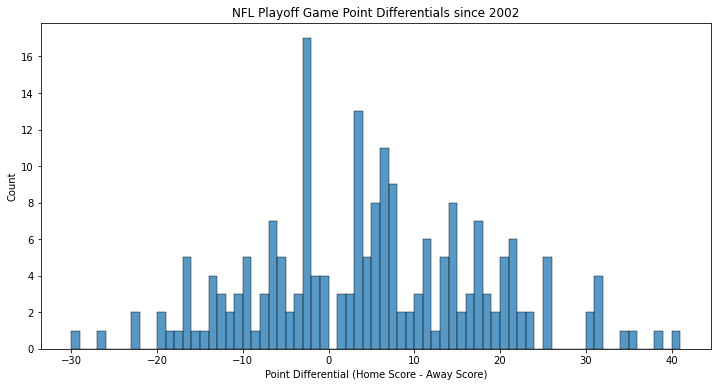

In [163]:
point_dif_plot = seaborn.histplot(data = playoffdf["point_dif"],binwidth = 1).set(title = "NFL Playoff Game Point Differentials since 2002",
                                                                                xlabel = "Point Differential (Home Score - Away Score)")

plt.gcf().set_size_inches(12, 6)

In [164]:
print("Mean Playoff Point Differential: " + str(playoffdf["point_dif"].mean()))
print("Median Playoff Point Differential: " + str(playoffdf["point_dif"].median()))
print("Playoff Point Differential Standard Deviation: " + str(playoffdf["point_dif"].std()))

Mean Playoff Point Differential: 4.5245098039215685
Median Playoff Point Differential: 4.5
Playoff Point Differential Standard Deviation: 13.397095018358943


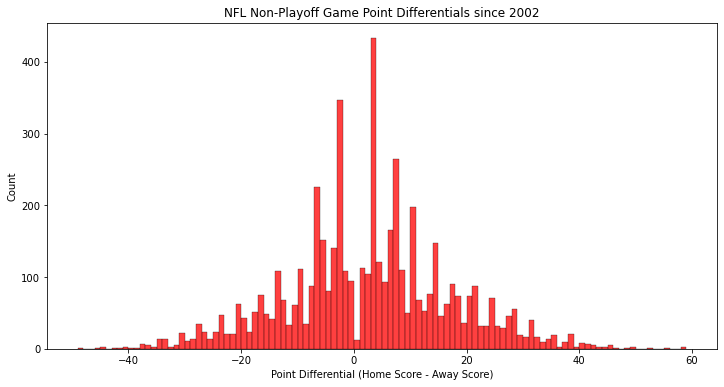

In [165]:
point_dif_plot = seaborn.histplot(data = nonplayoffdf["point_dif"],binwidth = 1,color = 'red').set(title = "NFL Non-Playoff Game Point Differentials since 2002",
                                                                                xlabel = "Point Differential (Home Score - Away Score)")

plt.gcf().set_size_inches(12, 6)

In [166]:
print("Mean Non-Playoff Point Differential: " + str(nonplayoffdf["point_dif"].mean()))
print("Median Non-Playoff Point Differential: " + str(nonplayoffdf["point_dif"].median()))
print("Non-Playoff Point Differential Standard Deviation: " + str(nonplayoffdf["point_dif"].std()))

Mean Non-Playoff Point Differential: 2.248051701197491
Median Non-Playoff Point Differential: 3.0
Non-Playoff Point Differential Standard Deviation: 14.675768889437645


In the playoff graph, despite the peak at -3, the graph appear to be more shifted to the right than the non-playoff game graph. This is further reflected in the mean point differentials, as playoff games seem to favor the home team by two more points than in regular games. 

One thing to keep in mind here is that during the playoffs, the teams playing at home are the teams who finished higher in the standing during the regular season. This makes it difficult to determine if the home teams are winning more because they are the better team or if the home field advantage is greater during the playoffs. In the regular season, we didn't need to worry about this, because playing at home and being the better team are indpendent of each other. Let's see the distribution of elo_dif for playoff games. 

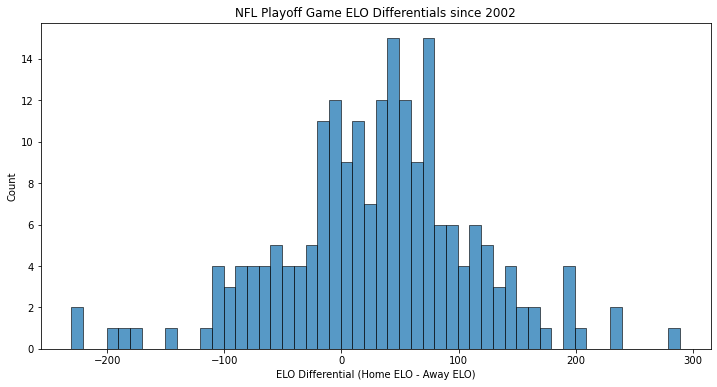

In [167]:
point_dif_plot = seaborn.histplot(data = playoffdf["elo_dif"],binwidth = 10).set(title = "NFL Playoff Game ELO Differentials since 2002",
                                                                                xlabel = "ELO Differential (Home ELO - Away ELO)")

plt.gcf().set_size_inches(12, 6)

In [168]:
print("Mean Playoff ELO Differential: " + str(playoffdf["elo_dif"].mean()))
print("Median Playoff ELO Differential: " + str(playoffdf["elo_dif"].median()))
print("Playoff ELO Differential Standard Deviation: " + str(playoffdf["elo_dif"].std()))

home_team_higher_count = len(playoffdf[playoffdf["elo_dif"] > 0])*100
num_of_playoff_games = len(playoffdf)

print("Percentage of playoff games where the home team's ELO was higher: " + str(home_team_higher_count/num_of_playoff_games))

Mean Playoff ELO Differential: 30.4988350109104
Median Playoff ELO Differential: 36.21406025672002
Playoff ELO Differential Standard Deviation: 82.53456092782599
Percentage of playoff games where the home team's ELO was higher: 66.17647058823529


As I suspected, home teams in the playoff usually have a higher ELO, so it makes sense that home teams win more often in the playoffs than they do in the regular season. 

In [169]:
ttest_ind(playoffdf["point_dif"],nonplayoffdf["point_dif"])

Ttest_indResult(statistic=2.18052941745437, pvalue=0.029260765399616678)

The hypothesis test looking at point differential between playoff and non-playoff games returns a p-value of .029, which indicates a difference between the two means. However, this does not tell us if home field advantage is greater in the playoffs or if the difference is a result of better teams playing at home in the playoffs. Regardless, we can say that home teams, on average, win by more points in the playoffs than they do in the regular season. 

## Examining the Effects of Rest

NFL games take place primarily on Sundays. However, each week, there is usually one game each on Monday and Thursday. Occasionally, there are games on Saturday late in the season. During 2020, due to COVID, there was even a game played on Wednesday. Additionally, each team gets a bye week each season where they don't have a game. This results in games where one team has had more days off than their opponent. Take, for example, a team that plays on a Monday night and then again the following Sunday. That is 6 days of rest. Let's say their opponent just had their bye week, and their last game before the bye week was on a Thursday night. That is 17 days of rest. While this is a drastic example, games happen all the time featuring one team who is more rested than the other. Let's examine if the difference in rest betweem the two teams affects the outcome.

For games that occur in week 1, I will set the rest differential to 10 days, since that is usually the amount of time in between the last preseason game and the first regular season game. It wouldn't really make sense to count the days since the end of last season, since so much time has passed for both teams. 

In [170]:
# Create a dictionary mapping team abbreviations to a list with all of the dates that team played on
dates_dict = {"CHI":[],"DET":[],"GB":[],"MIN":[],
                 "ATL":[],"CAR":[],"NO":[],"TB":[],
                 "DAL":[],"NYG":[],"PHI":[],"WSH":[],
                "ARI":[],"LAR":[],"SEA":[],"SF":[],
                "BAL":[],"CIN":[],"CLE":[],"PIT":[],
                 "HOU":[],"IND":[],"JAX":[],"TEN":[],
                 "BUF":[],"MIA":[],"NE":[],"NYJ":[],
                "DEN":[],"KC":[],"LAC":[],"LV":[]}

# Add the dates that each team played on
for index,row in joineddf.iterrows():
    dates_dict.get(joineddf.at[index,'away']).insert(0,joineddf.at[index,'date'])
    dates_dict.get(joineddf.at[index,'home']).insert(0,joineddf.at[index,'date'])
    
# Add the dates of the neutral site games that were omitted, as they affect rest
for index,row in neutralsitegames.iterrows():
    dates_dict.get(neutralsitegames.at[index,'away']).insert(0,neutralsitegames.at[index,'date'])
    dates_dict.get(neutralsitegames.at[index,'home']).insert(0,neutralsitegames.at[index,'date'])
    

for team in dates_dict.keys():
    l = dates_dict.get(team)
    l = list(dict.fromkeys(l)) #remove duplicate dates, since no teams play more than once per day
    l.sort() #sort the dates from earliest to latest
    dates_dict[team] = l
    
    
#initialize rest columns
joineddf["home_rest"] = 0
joineddf["away_rest"] = 0
joineddf["rest_dif"] = 0

for index,row in joineddf.iterrows():
    date = joineddf.at[index,'date']
    homeabbr = joineddf.at[index,'home'] 
    awayabbr = joineddf.at[index,'away']
    
    idxOfHome = dates_dict.get(homeabbr).index(date)
    idxOfAway = dates_dict.get(awayabbr).index(date)
    
    
    # If the date is the earliest for a team, we can't access the date at the index before. In this case,
    # set the rest differential to 10 days
    if idxOfHome == 0: 
        homeRest = 10
    else:
        #Days between curr game and last game
        homeRest = (dates_dict.get(homeabbr)[idxOfHome] - dates_dict.get(homeabbr)[idxOfHome - 1]).days
        
    if idxOfAway == 0: 
        awayRest = 10
    else:
        awayRest = (dates_dict.get(awayabbr)[idxOfAway] - dates_dict.get(awayabbr)[idxOfAway - 1]).days 
    
    #if game was week 1, set rest to 10 days
    if joineddf.at[index,'week'] == 1:
        joineddf.at[index,'home_rest'] = 10
        joineddf.at[index,'away_rest'] = 10
    else:
        joineddf.at[index,'home_rest'] = homeRest
        joineddf.at[index,'away_rest'] = awayRest
        
    
    joineddf.at[index,'rest_dif'] = joineddf.at[index,'home_rest'] - joineddf.at[index,'away_rest']
    
joineddf["rest_dif"].value_counts()

 0      3636
-1       400
 1       308
 7       280
-3       237
-7       224
 3       175
 6        54
-4        34
-8        25
-6        24
-2        23
 4        19
 8        16
 2         8
-246       1
 252       1
Name: rest_dif, dtype: int64

All of these rest differentials seem reasonable except for the one -246 and 252. These are due to an oversight on my part. In 2017, the Tampa Bay Buccaneers vs Miami Dolphins week 1 game was postponed due to a hurricane. This led to both teams starting the season in week 2. I will manually set the rest to 17 days for both teams for this game, to account for the time since they last played.

In [171]:
joineddf.at[3983,"away_rest"] = 17
joineddf.at[3983,"rest_dif"] = joineddf.at[3983,"home_rest"] - joineddf.at[3983,"away_rest"]

joineddf.at[3989,"home_rest"] = 17
joineddf.at[3989,"rest_dif"] = joineddf.at[3989,"home_rest"] - joineddf.at[3989,"away_rest"]

joineddf["rest_dif"].value_counts()

 0     3636
-1      400
 1      308
 7      280
-3      237
-7      224
 3      175
 6       54
-4       34
-8       25
-6       24
-2       23
 4       19
 8       16
 2        8
-11       1
 10       1
Name: rest_dif, dtype: int64

Now, everything appear to be accurate. Looking at the value counts, it makes sense that the majority of games have a rest differential of 0, since most games are played on Sundays, and if both teams played the previous Sunday, the rest_dif is zero. Let's look at the relationship between rest_dif and point_dif

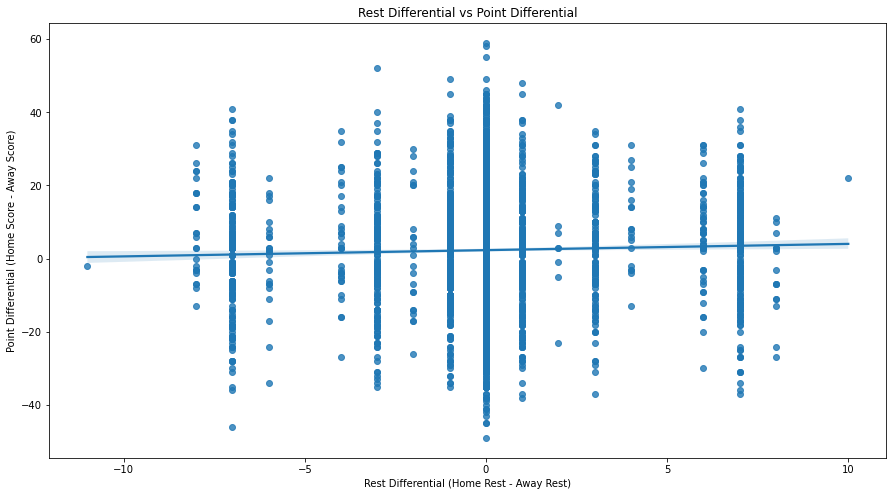

In [172]:
point_dif_elo_scatter = seaborn.regplot(y=joineddf["point_dif"],x=joineddf["rest_dif"]).set(title = "Rest Differential vs Point Differential",
                                                                                ylabel = "Point Differential (Home Score - Away Score)"
                                                                                             ,xlabel = "Rest Differential (Home Rest - Away Rest)")
plt.gcf().set_size_inches(15,8)

In [173]:
mod = smf.ols(formula='point_dif ~ rest_dif', data=joineddf)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              point_dif   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.874
Date:                Fri, 16 Dec 2022   Prob (F-statistic):             0.0273
Time:                        11:53:02   Log-Likelihood:                -22417.
No. Observations:                5465   AIC:                         4.484e+04
Df Residuals:                    5463   BIC:                         4.485e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3289      0.198     11.768      0.0

After examining the scatterplot and looking at the statistics of the linear regression, it appear there is a very slight linear relationship between point_dif and rest_dif, as indicated by the p-value of .027 However, the r-squared value is extremely small, so barely any of the variance in point differential can be explained by rest differential. 

Let's try to only look at games with rest differential with absolute value of at least 4 days

In [174]:
joineddf["rest_dif_abs"] = joineddf["rest_dif"].apply(lambda x: abs(x))


joineddf["higher_rest_dif_won"] = False #Did the team with more rest win?
for index, row in joineddf.iterrows():
    rest_dif = joineddf.at[index,'rest_dif']
    point_dif = joineddf.at[index,'point_dif']
    
    joineddf.at[index,"higher_rest_dif_won"] = ((rest_dif*point_dif) > 0)

seven_days_restdf = joineddf[joineddf["rest_dif_abs"] >= 4]
less_than_seven_days_restdf = joineddf[joineddf["rest_dif_abs"] < 4]

#Remove games with rest_dif of zero, since neither team had an advantage
less_than_seven_days_restdf = less_than_seven_days_restdf[less_than_seven_days_restdf["rest_dif_abs"] != 0]

print("Percent of the time the team with more rest won when |rest differential| < 4: " + 
     str(less_than_seven_days_restdf["higher_rest_dif_won"].mean()*100))

print("Percent of the time the team with more rest won when |rest differential| >= 4: " + 
     str(seven_days_restdf["higher_rest_dif_won"].mean()*100))


Percent of the time the team with more rest won when |rest differential| < 4: 48.39270199826238
Percent of the time the team with more rest won when |rest differential| >= 4: 55.45722713864307


Interestingly, when teams have more than 4 days more rest than their opponent, they win 55% of the time, as opposed to 48% of the time if they have between 1-4 days more rest than their opponent. 

## Hypothesis Tests for Rest Differential

Let's run another t-test to see if this difference is statictically significant.

In [175]:
ttest_ind(seven_days_restdf["higher_rest_dif_won"],less_than_seven_days_restdf["higher_rest_dif_won"])

Ttest_indResult(statistic=2.924313688086175, pvalue=0.0034946920243344613)

This is the lowest p-value we have seen so far. We can be very confident that teams with more than 4 days of rest than their opponent win at a higher rate than teams with less rest. It appears that while rest_dif might not be a good predictor of point differential, it does give us information about which team will win. 

## Vegas Accuracy Over Time

The final thing I want to look at in this analysis is if vegas betting lines have gotten more accurate over time.

One of the most common ways to bet NFL games is "against the spread." For each game, the sportsbooks set which team they think will win and by how many points. For example, next Sunday (December 18, 2022), Cincinnati plays Tampa Bay. The vegas line is Cincinnati minus 3.5, which means they think Cincinnati will win by 3.5 points. This score is impossible, since there is no way to score half a point, but the line is set this way to make bettors pick a side. If you bet Cincinnati against the spread, you win if Cincinnati wins by 4 or more points. If you bet Tampa Bay, Tampa needs to either lose by 3 or fewer, tie, or win outright. For a more detailed explanation of how this works, check out [this link](https://www.actionnetwork.com/education/point-spread).

Let's see how the accuracy of these spreads have changed over time. Let's add a new column that indicates the difference in the vegas line and the actual point differential. Note: if vegas thinks each team is equally likely to win, it sets the spread at zero, and you just bet on which team you think will win. This is called a PICK.

In [176]:
joineddf["adj_spread"] = 0 #the spread in terms of the home team
joineddf["vegas_error"] = 0 #number of points the vegas spread differed from the actual score


for index, row in joineddf.iterrows():
    if joineddf.at[index,'team_favorite_id'] == joineddf.at[index,'home']:
        
        # Since the spread is negative by default, make it positive if the home team was favored
        joineddf.at[index,"adj_spread"] = -1*joineddf.at[index,'spread_favorite']
        
    else:
        joineddf.at[index,"adj_spread"] = joineddf.at[index,'spread_favorite']
        
    joineddf.at[index,"vegas_error"] = abs(joineddf.at[index,"adj_spread"] - joineddf.at[index,"point_dif"])
    


In [177]:
joineddf["vegas_error"].mean()

10.37932296431839

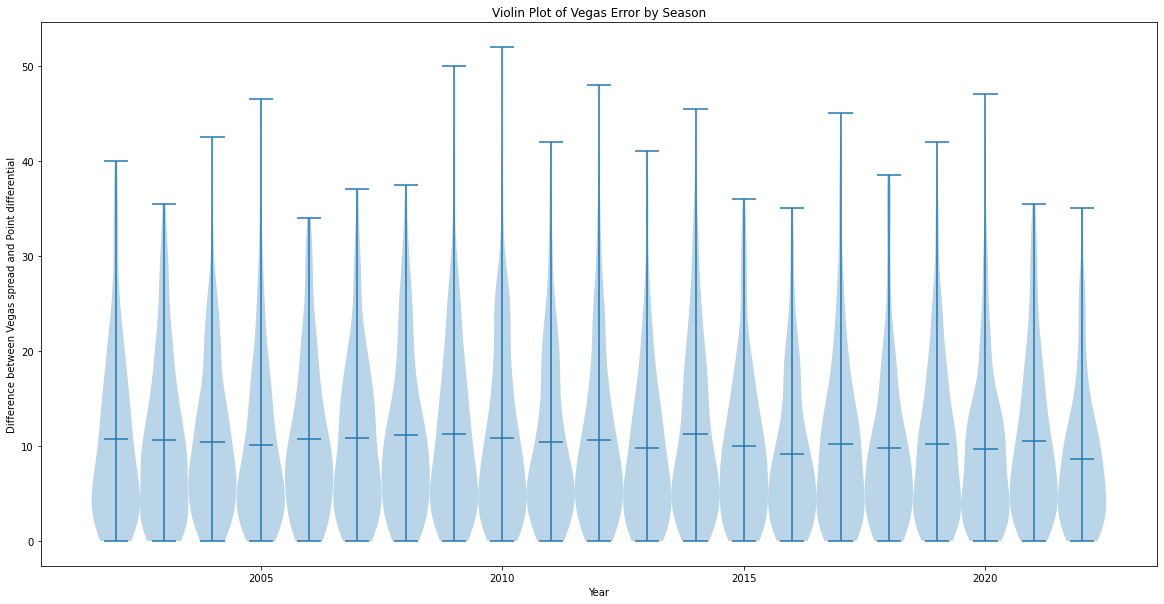

In [178]:
vegas_error_by_year = []
for x in range(2002,2023):
    
    vegas_error_by_year.append(joineddf.loc[joineddf["season"] == x]["vegas_error"].values)

fig, ax = plt.subplots()
plt.violinplot(vegas_error_by_year,list(range(2002,2023)),widths=1,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Difference between Vegas spread and Point differential")
ax.set_title("Violin Plot of Vegas Error by Season")
fig.savefig("violin.png")

plt.gcf().set_size_inches(20, 10)

Looking at this plot, it doesn't appear that there is a significant difference in vegas accuracy since 2022. Now, let's see if the vegas_error decreases as the week of the season increases. As the season goes on, there is more information available about teams, so it seems reasonable to believe that vegas spreads become more accurate as the season goes on. 

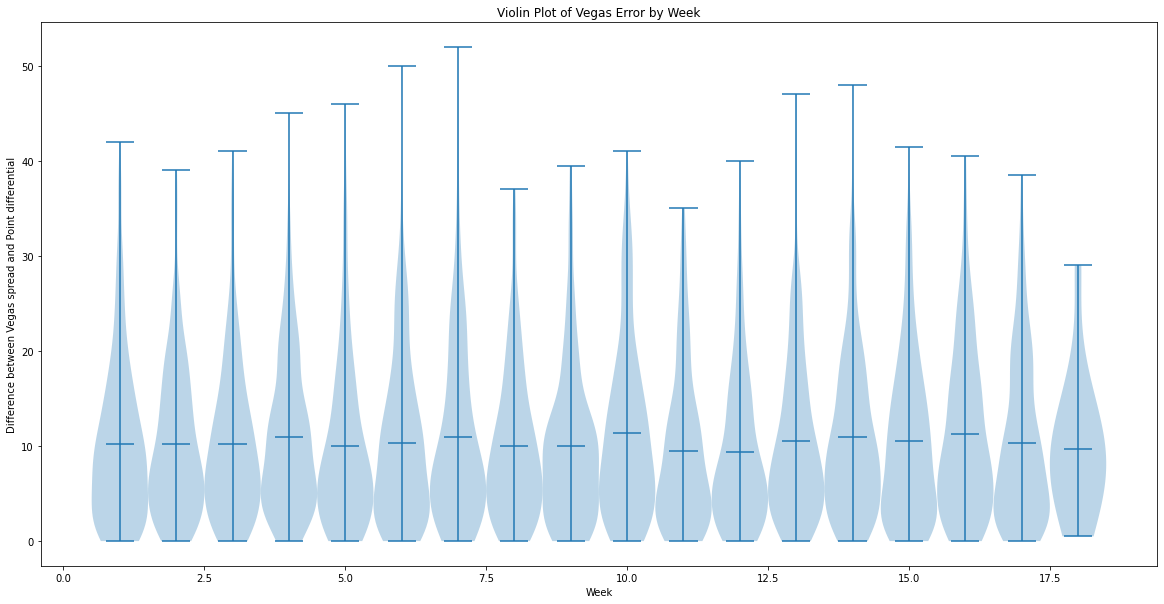

In [179]:
vegas_error_by_week = []
for x in range(1,19):
    
    vegas_error_by_week.append(joineddf.loc[joineddf["week"] == x]["vegas_error"].values)

fig, ax = plt.subplots()
plt.violinplot(vegas_error_by_week,list(range(1,19)),widths=1,showmeans=True)
ax.set_xlabel("Week")
ax.set_ylabel("Difference between Vegas spread and Point differential")
ax.set_title("Violin Plot of Vegas Error by Week")
fig.savefig("violin.png")

plt.gcf().set_size_inches(20, 10)

Once again, there doesn't appear to be a trend as the weeks increase. I think that both of these violin plots demonstrate the random nature of NFL games and the difficulty of predicting the outcome. Since 2002, the amount of data available and the sophistication of the sports betting models has undoubtedly increased, but this hasn't resulted in an increased ability for vegas to predict the spread of a game.

## Conclusion / Overview of Insights Attained

My main takeaway from this analysis was that NFL games are very hard to predict due to their random nature. With that being said, while there weren't any major takeaways from the analysis of vegas point spreads over time, I did learn some interesting points about the effects of rest, home field advantage, and the effects that division and playoff games have on an outcome. While none of these findings will help you beat Vegas, hopefully they gave you a better look at some of the factors that influence NFL games.

Hopefully this walkthrough also provided a nice walkthroughof the data science process gave you a good idea about the things that are important to consider when analyzing and visualing a dataset (or two!), as well as some of the ways to check and see if your findings are significant. 



## Links to Datasets

[FiveThiryEight Dataset](): 
[Betting Line Dataset](): 